## Imports

In [1]:
import itertools
import json
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import numpy as np
import pandas as pd
import re
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from spellchecker import SpellChecker
from joblib import dump, load

[nltk_data] Downloading package punkt to /Users/helishah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/helishah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import time
import datetime

## Data

Load the cleaned reviews:

In [3]:
%%time
data = "dataset/preprocessed_dataset.csv"
df = pd.read_csv(data)
df = df[df.reviewTextPreprocessed.notna()]
df.head()

CPU times: user 16.8 s, sys: 3.51 s, total: 20.3 s
Wall time: 20.9 s


,reviewTextPreprocessed,overall,verified
0,looks even better in person be careful to not ...,5,True
1,when you do not want to spend a whole lot of c...,5,True
2,so the case came on time i love the design im ...,3,True
3,do not care for it gave it as a gift and they...,2,True
4,i liked it because it was cute but the studs f...,4,True


In [4]:
df.shape

(5679421, 3)

See proportion of positive ($>3$) and critical ($\leq 3$) reviews:

In [5]:
df["positive"] = df.overall > 3

In [6]:
df.groupby("positive").size()

positive
False    1124686
True     4554735
dtype: int64

In [7]:
df.groupby("positive").size()/(df.shape[0])

positive
False    0.198028
True     0.801972
dtype: float64

The class to predict is highly unbalanced. We can sample in order to have a balanced class:

In [8]:
sample_size = 500000 # needs to be less than the number of observations in the minority class
sample_df = df.groupby('positive').apply(lambda x: x.sample(sample_size))

In [9]:
sample_df = sample_df.reset_index(level=0, drop=True) # remove outer level of multiindex

In [10]:
sample_df.groupby("positive").size()

positive
False    500000
True     500000
dtype: int64

#### Choice: Unbalanced or Balanced Classes

Definition of unbalanced `X` and `y` (class to predict). The classification with this choice should be better at predicting sentiment on the reviews from the Amazon dataset.

In [11]:
# X = df.reviewTextPreprocessed.values
# y = df.positive.values

Definition of balanced `X` and `y` (class to predict). The classification with this choice should be better at predicting sentiment on tweets (which might not be unbalanced in the same way as this dataset).

In [12]:
X = sample_df.reviewTextPreprocessed.values
y = sample_df.positive.values

## Order of operations from now on:

First of all, we define a list of stopwords.

The next step is the preprocessing needed to obtain a suitable representation of the reviews, which are:

- Tokenization
- Spelling correction
- Stop words removal
- (Stemming)

After these operations, the reviews are going to be passed to a vectorizer in order to obtain the final representation for the classifiers.

Stemming can be achieved using two different libraries: NLTK and PyStemmer. PyStemmer is faster, but needs Visual C++ Build Tools installed. Please choose the relevant code you prefer to run.

#### Rough execution times:

#### NLTK

- Tokenization, 2min 59s
- Spell check and correction, 15min 12s
- Stop words removal, 44.6 s
- Stemming, 5min 56s (Porter) 4min 59s (Lancaster)
- Vectorization, 50.8 s (Porter), 49.5 s(Lancaster)

#### PyStemmer

Class that performs

- Tokenization
- Spell check and correction (parameter `preprocessor`)
- Stop words removal (parameter `stop_words`)
- Stemming (with `pystemmer`)
- Vectorization

7min 44s

### Definition of the list of Stop-words

In [13]:
from nltk.corpus import stopwords
stopws = stopwords.words("english")

The list of stop words needs to be preprocessed in the same way as the reviews. We define the  dictionaries needed for the preprocessing, as in the previous notebook:

In [14]:
emoticon_repl = {
    # positive emoticons
    r":-?d+": " good ", r":[- ]?\)+": " good ", r";-?\)+": " good ", # ;). ;)). ;-), ecc.
    r"\(+-?:": " good ", r"=\)+" : " good ", r"\b<3\b" : " good ",    
    # negative emoticons
    r"[\s\r\t\n]+:/+": " bad ", r":\\+": " bad ", r"[\s\r\t\n]+\)-?:": " bad ",  # ):, )):, )-:, ecc.
    r":-?\(+": " bad ", r"[\s\t\r\n]+d+-?:": " bad "
}

contracted_repl = {
    # casi particolari
    r"won\'t" : "will not", r"won\'" : "will not", r"can\'t": "can not", r"shan\'t": "shall not",
    r"shan\'": "shall not", r"ain\'t": "is not", r"ain\'": "is not",
    # casi generali
    r"n\'t": " not", r"\'t": " not", r"n\'": " not", r"\'s": " is", r"\'ve": " have", 
    r"\'re": " are", 
    r"\'ll": " will", r"\'d": " would",
}

with open('dataset/slang_subset_manual.json', 'r') as fid:
    slang_repl = json.load(fid)

Same preprocessing function as in the previous notebook:

In [15]:
def preprocess(sent, translate_slang = True):
    
    sent = sent.lower()
    sent = re.sub(r'^<div id="video.*>&nbsp;', '', sent)
    sent = re.sub('https?://[A-Za-z0-9./]+', '', sent)
    
    for k in emoticon_repl:
        sent = re.sub(k, emoticon_repl[k], sent)

    if translate_slang:
        for k in slang_repl:
            sent = re.sub(r"\b"+re.escape(k)+r"\b", slang_repl[k], sent)
        
    for k in contracted_repl:
        sent = re.sub(k, contracted_repl[k], sent)
    
    sent = re.sub('[/]+', ' ', sent)
    sent = re.sub('[^A-Za-z0-9-_ ]+', '', sent)
    sent = re.sub('\b\d+\b', '', sent)
    
    return sent

In [16]:
prep_stopws = [preprocess(el) for el in stopws]

Words containing "not" are important for our tasks

In [17]:
np.array(prep_stopws[-36:])

array(['ain', 'aren', 'are not', 'couldn', 'could not', 'didn', 'did not',
       'doesn', 'does not', 'hadn', 'had not', 'hasn', 'has not', 'haven',
       'have not', 'isn', 'is not', 'ma', 'mightn', 'might not', 'mustn',
       'must not', 'needn', 'need not', 'shan', 'shall not', 'shouldn',
       'should not', 'wasn', 'was not', 'weren', 'were not', 'won',
       'will not', 'wouldn', 'would not'], dtype='<U10')

In [18]:
prep_stopws = prep_stopws[:-36]

Other words to remove from the stop words:

In [19]:
for word in ["not", "very", "don", "do not"]:
    prep_stopws.remove(word)

In [20]:
prep_stopws.extend(["youse", "would"]) # needed for consistency with spell checker

## Tokenization/Spell Correction/StopWordsRemoval/Stemming

### NLTK

In [21]:
from nltk.tokenize import word_tokenize
def tokenize_reviews(reviews):
    tokenized_reviews = [word_tokenize(review) for review in reviews]
    return tokenized_reviews

In [22]:
%%time
X_tokenized = tokenize_reviews(X)

CPU times: user 4min 54s, sys: 36.8 s, total: 5min 31s
Wall time: 10min 28s


Spelling correction:

In [23]:
def fix_spelling_mistakes(reviews, dist=1):
    spell = SpellChecker(distance=dist)
    reviews_with_right_spell = []
    for review in reviews:
        corrected_review = [spell.correction(word) for word in review]
        reviews_with_right_spell.append(corrected_review)
    return reviews_with_right_spell

In [24]:
%%time
X_spellchecked = fix_spelling_mistakes(X_tokenized)

CPU times: user 42min 36s, sys: 43.1 s, total: 43min 19s
Wall time: 43min 34s


Stop words removal:

In [25]:
%%time
X_noStopWords = []
for review in X_spellchecked:
        cleaned_review = [word for word in review if word not in prep_stopws]
        X_noStopWords.append(cleaned_review)

CPU times: user 1min 56s, sys: 41.8 s, total: 2min 38s
Wall time: 2min 51s


In [26]:
from nltk.stem import PorterStemmer, LancasterStemmer

In [27]:
def stem_reviews(reviews, stemmer_name="Porter"):
    if stemmer_name == "Porter":
        stemmer = PorterStemmer()
    elif stemmer_name == "Lancaster":
        stemmer = LancasterStemmer()
    else:
        raise SystemError
    stemmed_reviews = []
    for review in reviews:
        stemmed_reviews.append([stemmer.stem(word) for word in review])
    return stemmed_reviews

In [28]:
%%time
X_Porter = stem_reviews(X_noStopWords, stemmer_name = "Porter")

CPU times: user 13min 41s, sys: 50.6 s, total: 14min 32s
Wall time: 34min 8s


In [29]:
%%time
X_Lancaster = stem_reviews(X_noStopWords, stemmer_name = "Lancaster")

CPU times: user 11min 47s, sys: 1min 29s, total: 13min 16s
Wall time: 14min 10s


### PyStemmer (needs Visual C++ installed)

Definition of the class StemmedTdidfVectorized.

- `sklearn`'s `TfidfVectorizer` takes care of tokenization, stop-word removal, vectorization
- `pystemmer` takes care of stemming.

In [30]:
import Stemmer
english_stemmer = Stemmer.Stemmer('en')

ModuleNotFoundError: No module named 'Stemmer'

In [31]:
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))

## Train-test split

In [32]:
from sklearn.model_selection import train_test_split

#### NLTK

Here we are train/test splitting the set of reviews that is already tokenized and stemmed, to be passed to TfidfVectorizer for representation.

In [33]:
X_train_Porter, X_test_Porter, y_train, y_test = train_test_split(X_Porter, y,
                                                                  test_size=0.33, random_state=42)
X_train_Lancaster, X_test_Lancaster, y_train, y_test = train_test_split(X_Lancaster, y,
                                                                        test_size=0.33, random_state=42)

#### Pystemmer

Here we are train/test splitting the preprocessed set of reviews to be passed to `StemmedTfidfVectorizer` for tokenization+stemming+representation.

In [34]:
X_train_pystemmer, X_test_pystemmer, y_train, y_test = train_test_split(X, y,
                                                                  test_size=0.33, random_state=42)

## Text Representation

#### NLTK

In [35]:
def rebuild_reviews(reviews):
    rebuilt_reviews = []
    for review in reviews:
        rebuilt_reviews.append(" ".join(review))
    return rebuilt_reviews

In [36]:
X_train_Porter = rebuild_reviews(X_train_Porter)
X_test_Porter = rebuild_reviews(X_test_Porter)
X_train_Lancaster = rebuild_reviews(X_train_Lancaster)
X_test_Lancaster = rebuild_reviews(X_test_Lancaster)

In [37]:
%%time
tfidf_vect_Porter = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2))
X_train_tfidf_Porter = tfidf_vect_Porter.fit_transform(X_train_Porter)

CPU times: user 1min 58s, sys: 20.7 s, total: 2min 19s
Wall time: 2min 46s


In [38]:
%%time
X_test_tfidf_Porter = tfidf_vect_Porter.transform(X_test_Porter)

CPU times: user 25.3 s, sys: 819 ms, total: 26.2 s
Wall time: 26.6 s


In [39]:
%%time
tfidf_vect_Lancaster = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2))
X_train_tfidf_Lancaster = tfidf_vect_Lancaster.fit_transform(X_train_Lancaster)

CPU times: user 1min 40s, sys: 5.4 s, total: 1min 45s
Wall time: 1min 47s


In [40]:
%%time
X_test_tfidf_Lancaster = tfidf_vect_Lancaster.transform(X_test_Lancaster)

CPU times: user 25.3 s, sys: 750 ms, total: 26 s
Wall time: 26.5 s


In [41]:
dump(tfidf_vect_Porter, 'joblib_data/tfidf_vect_Porter.joblib')
dump(tfidf_vect_Lancaster, 'joblib_data/tfidf_vect_Lancaster.joblib')

['joblib_data/tfidf_vect_Lancaster.joblib']

#### Pystemmer

In [42]:
%%time
spell = SpellChecker(distance=1)
tfidf_vect_pystemmer = StemmedTfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2),
                                              preprocessor = spell.correction,
                                              stop_words = prep_stopws)
X_train_tfidf_pystemmer = tfidf_vect_pystemmer.fit_transform(X_train_pystemmer)

NameError: name 'english_stemmer' is not defined

In [43]:
%%time
X_test_tfidf_pystemmer = tfidf_vect_pystemmer.transform(X_test_pystemmer)

NotFittedError: StemmedTfidfVectorizer - Vocabulary wasn't fitted.

In [44]:
dump(tfidf_vect_pystemmer, 'joblib_data/tfidf_vect_pystemmer.joblib') 

['joblib_data/tfidf_vect_pystemmer.joblib']

####  No stemming

In [45]:
X_train_nostemmer, X_test_nostemmer, y_train, y_test = train_test_split(X, y,
                                                                  test_size=0.33, random_state=42)

In [46]:
%%time
spell = SpellChecker(distance=1)
tfidf_vect_nostemmer = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2),
                                              preprocessor = spell.correction,
                                              stop_words = prep_stopws)
X_train_tfidf_nostemmer = tfidf_vect_nostemmer.fit_transform(X_train_nostemmer)

CPU times: user 6min 31s, sys: 22.6 s, total: 6min 54s
Wall time: 7min 20s


In [47]:
%%time
X_test_tfidf_nostemmer = tfidf_vect_nostemmer.transform(X_test_nostemmer)

CPU times: user 2min 45s, sys: 11.7 s, total: 2min 57s
Wall time: 3min 19s


In [48]:
dump(tfidf_vect_nostemmer, 'joblib_data/tfidf_vect_nostemmer.joblib') 

['joblib_data/tfidf_vect_nostemmer.joblib']

# Classification

## NB Classifier

In [49]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score

Accessory functions:

In [50]:
def print_top_features(vectorizer, clf, n = 10):
    fnames = vectorizer.get_feature_names()
    top_pos = np.argsort(clf.coef_[0])[-n:]
    top_pos = top_pos[::-1]
    print("Most discriminative features:\n",
          ", ".join(fnames[j] for j in top_pos))

In [51]:
def score_model(clf, X_train, X_test, y_train, y_test, probabilities = True):
    train_score = clf.score(X_train, y_train) # Train Accuracy
    test_score = clf.score(X_test, y_test)    # Test Accuracy
    
    predictions = clf.predict(X_test)

    prec = precision_score(y_test, predictions) # Precision
    rec = recall_score(y_test, predictions) # Recall
    f1 = f1_score(y_test, predictions) # F1
    f2 = fbeta_score(y_test, predictions, 2) # F2
    cm = confusion_matrix(y_test, predictions)
    if probabilities:
        proba = clf.predict_proba(X_test)

        precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])

        auc_score = auc(recall, precision)

        scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                          "Test Recall", "F1", "F2", "P/R AUC"]

        scores = [train_score, test_score, prec, rec, f1, f2, auc_score]

        print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

        print(classification_report(y_test, predictions, digits=5))

        plt.plot(recall, precision, label='Precision-Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
        plt.legend(loc="lower left")
        plt.show()
    else:
        scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                          "Test Recall", "F1", "F2"]

        scores = [train_score, test_score, prec, rec, f1, f2]

        print(("{:20s} {:.5f}\n"*6)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

        print(classification_report(y_test, predictions, digits=5))

###  No Stemmer

In [52]:
%%time
clf = MultinomialNB()
clf.fit(X_train_tfidf_nostemmer, y_train)

CPU times: user 303 ms, sys: 606 ms, total: 909 ms
Wall time: 1.57 s


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [53]:
print_top_features(tfidf_vect_nostemmer, clf, 50)

Most discriminative features:
 great, good, love, movie, not, very, excellent, one, like, product, well, great movie, case, loved, best, nice, phone, really, series, film, very good, time, story, show, awesome, good movie, watch, perfect, price, movies, works, get, dvd, much, enjoyed, quality, funny, see, buy, favorite, use, recommend, fun, little, taste, also, better, first, still, wonderful


In [54]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer)

CPU times: user 147 ms, sys: 272 ms, total: 419 ms
Wall time: 677 ms


Train Accuracy       0.83998
Test Accuracy        0.83328
Test Precision       0.84384
Test Recall          0.81812
F1                   0.83078
F2                   0.82313
P/R AUC              0.91102
              precision    recall  f1-score   support

       False    0.82334   0.84846   0.83571    164923
        True    0.84384   0.81812   0.83078    165077

   micro avg    0.83328   0.83328   0.83328    330000
   macro avg    0.83359   0.83329   0.83324    330000
weighted avg    0.83359   0.83328   0.83324    330000



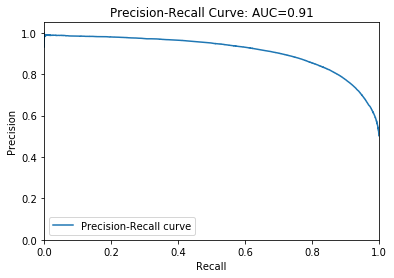

CPU times: user 1.36 s, sys: 517 ms, total: 1.88 s
Wall time: 2.97 s


In [55]:
%%time
score_model(clf, X_train_tfidf_nostemmer, X_test_tfidf_nostemmer, y_train, y_test)

In [56]:
dump(clf, 'joblib_data/clf_nb_nostemmer.joblib') 

['joblib_data/clf_nb_nostemmer.joblib']

### NLTK

#### Porter

In [57]:
%%time
clf = MultinomialNB()
clf.fit(X_train_tfidf_Porter, y_train)

CPU times: user 296 ms, sys: 625 ms, total: 922 ms
Wall time: 1.53 s


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [58]:
print_top_features(tfidf_vect_Porter, clf, 50)

Most discriminative features:
 great, good, love, movi, not, veri, like, excel, one, watch, product, phone, case, great movi, well, enjoy, film, time, work, nice, show, best, realli, thank, use, seri, stori, veri good, good movi, awesom, get, price, tast, perfect, make, recommend, buy, season, see, look, much, qualiti, funni, favorit, fun, love movi, wonder, fit, littl, go


In [59]:
%%time
predictions = clf.predict(X_test_tfidf_Porter)

CPU times: user 119 ms, sys: 391 ms, total: 510 ms
Wall time: 1.07 s


Train Accuracy       0.83717
Test Accuracy        0.83002
Test Precision       0.84206
Test Recall          0.81261
F1                   0.82707
F2                   0.81833
P/R AUC              0.90892
              precision    recall  f1-score   support

       False    0.81878   0.84744   0.83286    164923
        True    0.84206   0.81261   0.82707    165077

   micro avg    0.83002   0.83002   0.83002    330000
   macro avg    0.83042   0.83003   0.82997    330000
weighted avg    0.83043   0.83002   0.82997    330000



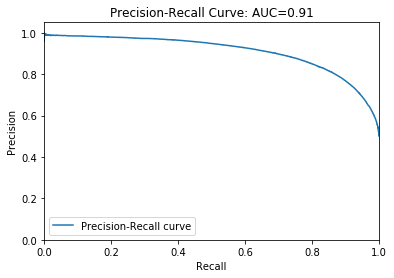

CPU times: user 1.31 s, sys: 236 ms, total: 1.55 s
Wall time: 1.86 s


In [60]:
%%time
score_model(clf, X_train_tfidf_Porter, X_test_tfidf_Porter, y_train, y_test)

In [61]:
dump(clf, 'joblib_data/clf_nb_porter.joblib') 

['joblib_data/clf_nb_porter.joblib']

#### Lancaster

In [62]:
%%time
clf = MultinomialNB()
clf.fit(X_train_tfidf_Lancaster, y_train)

CPU times: user 343 ms, sys: 663 ms, total: 1.01 s
Wall time: 1.72 s


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [63]:
print_top_features(tfidf_vect_Lancaster, clf, 50)

Most discriminative features:
 gre, good, lov, movy, not, very, excel, lik, on, produc, watch, real, phon, cas, gre movy, us, enjoy, film, tim, wel, act, work, nic, show, best, perfect, thank, sery, story, very good, good movy, awesom, get, ev, pric, tast, mak, recommend, see, buy, season, protect, look, much, qual, funny, favorit, charg, fun, lov movy


In [64]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster)

CPU times: user 142 ms, sys: 347 ms, total: 489 ms
Wall time: 835 ms


Train Accuracy       0.83517
Test Accuracy        0.82822
Test Precision       0.84070
Test Recall          0.81010
F1                   0.82512
F2                   0.81604
P/R AUC              0.90742
              precision    recall  f1-score   support

       False    0.81660   0.84635   0.83121    164923
        True    0.84070   0.81010   0.82512    165077

   micro avg    0.82822   0.82822   0.82822    330000
   macro avg    0.82865   0.82823   0.82816    330000
weighted avg    0.82866   0.82822   0.82816    330000



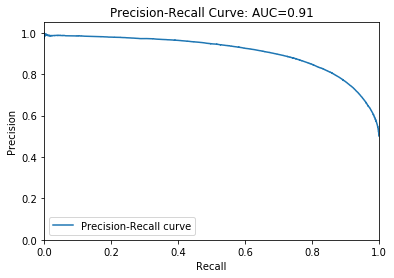

CPU times: user 1.29 s, sys: 198 ms, total: 1.49 s
Wall time: 1.78 s


In [65]:
%%time
score_model(clf, X_train_tfidf_Lancaster, X_test_tfidf_Lancaster, y_train, y_test)

In [66]:
dump(clf, 'joblib_data/clf_nb_lancaster.joblib') 

['joblib_data/clf_nb_lancaster.joblib']

###  PyStemmer

In [67]:
%%time
clf = MultinomialNB()
clf.fit(X_train_tfidf_pystemmer, y_train)

NameError: name 'X_train_tfidf_pystemmer' is not defined

In [68]:
print_top_features(tfidf_vect_pystemmer, clf, 50)

NotFittedError: StemmedTfidfVectorizer - Vocabulary wasn't fitted.

In [69]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer)

NameError: name 'X_test_tfidf_pystemmer' is not defined

In [70]:
%%time
score_model(clf, X_train_tfidf_pystemmer, X_test_tfidf_pystemmer, y_train, y_test)

NameError: name 'X_train_tfidf_pystemmer' is not defined

In [71]:
dump(clf, 'joblib_data/clf_nb_pystemmer.joblib') 

['joblib_data/clf_nb_pystemmer.joblib']

## Random forest

In [72]:
from sklearn.ensemble import RandomForestClassifier

### No stemmer

In [73]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_nostemmer, y_train)

CPU times: user 4h 52min 41s, sys: 1min 48s, total: 4h 54min 29s
Wall time: 41min 34s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [74]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer)

CPU times: user 37.1 s, sys: 2.91 s, total: 40 s
Wall time: 7.35 s


Train Accuracy       0.98485
Test Accuracy        0.82969
Test Precision       0.86700
Test Recall          0.77905
F1                   0.82068
F2                   0.79519
P/R AUC              0.90911
              precision    recall  f1-score   support

       False    0.79923   0.88037   0.83784    164923
        True    0.86700   0.77905   0.82068    165077

   micro avg    0.82969   0.82969   0.82969    330000
   macro avg    0.83311   0.82971   0.82926    330000
weighted avg    0.83313   0.82969   0.82926    330000



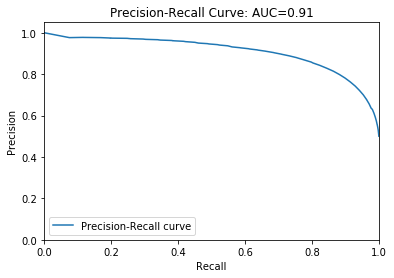

['joblib_data/clf_random_forest_nostemmer.joblib']

In [75]:
score_model(clf, X_train_tfidf_nostemmer, X_test_tfidf_nostemmer, y_train, y_test)
dump(clf, "joblib_data/clf_random_forest_nostemmer.joblib")

### Porter

In [76]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_Porter, y_train)

CPU times: user 4h 49min 45s, sys: 1min 24s, total: 4h 51min 9s
Wall time: 40min 56s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [77]:
%%time
predictions = clf.predict(X_test_tfidf_Porter)

CPU times: user 35.6 s, sys: 3.45 s, total: 39.1 s
Wall time: 7.45 s


Train Accuracy       0.98492
Test Accuracy        0.82976
Test Precision       0.86378
Test Recall          0.78320
F1                   0.82152
F2                   0.79809
P/R AUC              0.90976
              precision    recall  f1-score   support

       False    0.80153   0.87637   0.83728    164923
        True    0.86378   0.78320   0.82152    165077

   micro avg    0.82976   0.82976   0.82976    330000
   macro avg    0.83265   0.82979   0.82940    330000
weighted avg    0.83267   0.82976   0.82940    330000



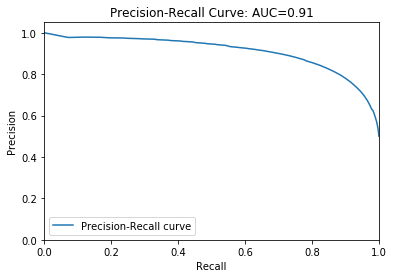

['joblib_data/clf_random_forest_porter.joblib']

In [78]:
score_model(clf, X_train_tfidf_Porter, X_test_tfidf_Porter, y_train, y_test)
dump(clf, "joblib_data/clf_random_forest_porter.joblib")

### Lancaster

In [79]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_Lancaster, y_train)

CPU times: user 4h 52min 5s, sys: 1min 11s, total: 4h 53min 16s
Wall time: 39min 52s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [80]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster)

CPU times: user 33.4 s, sys: 1.76 s, total: 35.2 s
Wall time: 5.68 s


Train Accuracy       0.98495
Test Accuracy        0.82676
Test Precision       0.86644
Test Recall          0.77280
F1                   0.81695
F2                   0.78988
P/R AUC              0.90766
              precision    recall  f1-score   support

       False    0.79479   0.88076   0.83557    164923
        True    0.86644   0.77280   0.81695    165077

   micro avg    0.82676   0.82676   0.82676    330000
   macro avg    0.83061   0.82678   0.82626    330000
weighted avg    0.83063   0.82676   0.82625    330000



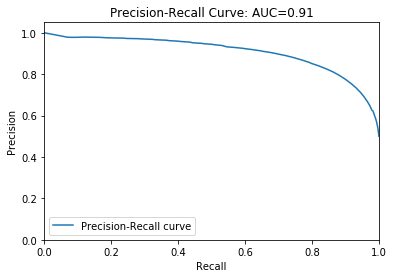

['joblib_data/clf_random_forest_lancaster.joblib']

In [81]:
score_model(clf, X_train_tfidf_Lancaster, X_test_tfidf_Lancaster, y_train, y_test)
dump(clf, "joblib_data/clf_random_forest_lancaster.joblib")

### Pystemmer

In [82]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_pystemmer, y_train)

NameError: name 'X_train_tfidf_pystemmer' is not defined

In [83]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer)

NameError: name 'X_test_tfidf_pystemmer' is not defined

In [84]:
score_model(clf, X_train_tfidf_pystemmer, X_test_tfidf_pystemmer, y_train, y_test)
dump(clf, "joblib_data/clf_random_forest_pystemmer.joblib")

NameError: name 'X_train_tfidf_pystemmer' is not defined

## TruncatedSVD
The X_train vector has around 50k features: for speeding up the training phase it may be good to use dimensionality reduction methods. Their goal is to preserve "expressive power" while reducing dataset dimensionality.
Because the TFIDF matrix is a sparse one, one of the best method for performing dimensionality reduction is "TruncatedSVD"

### No stemmer

In [85]:
%%time
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=200, random_state=42)
X_train_tfidf_nostemmer_svd = tsvd.fit_transform(X_train_tfidf_nostemmer)
X_test_tfidf_nostemmer_svd = tsvd.transform(X_test_tfidf_nostemmer)

CPU times: user 2min 50s, sys: 25.6 s, total: 3min 15s
Wall time: 2min 14s


### Porter

In [86]:
%%time
tsvd = TruncatedSVD(n_components=200, random_state=42)
X_train_tfidf_Porter_svd = tsvd.fit_transform(X_train_tfidf_Porter)
X_test_tfidf_Porter_svd = tsvd.transform(X_test_tfidf_Porter)

CPU times: user 2min 48s, sys: 21.6 s, total: 3min 10s
Wall time: 2min 6s


### Lancaster

In [87]:
%%time
tsvd = TruncatedSVD(n_components=200, random_state=42)
X_train_tfidf_Lancaster_svd = tsvd.fit_transform(X_train_tfidf_Lancaster)
X_test_tfidf_Lancaster_svd = tsvd.transform(X_test_tfidf_Lancaster)

CPU times: user 2min 49s, sys: 22.3 s, total: 3min 11s
Wall time: 2min 9s


### Pystemmer

In [88]:
%%time
tsvd = TruncatedSVD(n_components=200, random_state=42)
X_train_tfidf_pystemmer_svd = tsvd.fit_transform(X_train_tfidf_pystemmer)
X_test_tfidf_pystemmer_svd = tsvd.transform(X_test_tfidf_pystemmer)

NameError: name 'X_train_tfidf_pystemmer' is not defined

#### Store SVD-transformed dataset

In [89]:
dump(X_train_tfidf_nostemmer_svd, 'joblib_data/X_train_tfidf_nostemmer_svd.joblib')
dump(X_test_tfidf_nostemmer_svd, 'joblib_data/X_test_tfidf_nostemmer_svd.joblib')

['joblib_data/X_test_tfidf_nostemmer_svd.joblib']

In [90]:
dump(X_train_tfidf_Porter_svd, 'joblib_data/X_train_tfidf_Porter_svd.joblib')
dump(X_test_tfidf_Porter_svd, 'joblib_data/X_test_tfidf_Porter_svd.joblib')

['joblib_data/X_test_tfidf_Porter_svd.joblib']

In [91]:
dump(X_train_tfidf_Lancaster_svd, 'joblib_data/X_train_tfidf_Lancaster_svd.joblib')
dump(X_test_tfidf_Lancaster_svd, 'joblib_data/X_test_tfidf_Lancaster_svd.joblib')

['joblib_data/X_test_tfidf_Lancaster_svd.joblib']

In [92]:
dump(X_train_tfidf_pystemmer_svd, 'joblib_data/X_train_tfidf_pystemmer_svd.joblib')
dump(X_test_tfidf_pystemmer_svd, 'joblib_data/X_test_tfidf_pystemmer_svd.joblib')

NameError: name 'X_train_tfidf_pystemmer_svd' is not defined

## Random Forest with TruncatedSVD Dataset

### No stemmer

In [93]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_nostemmer_svd, y_train)

CPU times: user 19min 58s, sys: 7.98 s, total: 20min 6s
Wall time: 2min 55s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [94]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer_svd)

CPU times: user 9.77 s, sys: 1.63 s, total: 11.4 s
Wall time: 3.91 s


Train Accuracy       0.98489
Test Accuracy        0.79256
Test Precision       0.81439
Test Recall          0.75809
F1                   0.78523
F2                   0.76872
P/R AUC              0.87409
              precision    recall  f1-score   support

       False    0.77354   0.82706   0.79940    164923
        True    0.81439   0.75809   0.78523    165077

   micro avg    0.79256   0.79256   0.79256    330000
   macro avg    0.79396   0.79258   0.79232    330000
weighted avg    0.79397   0.79256   0.79232    330000



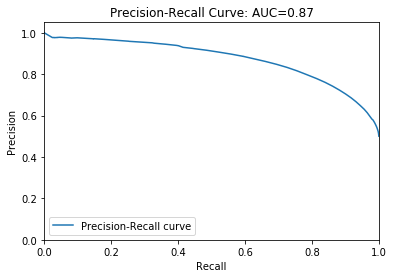

['joblib_data/clf_random_forest_nostemmer_svd.joblib']

In [95]:
score_model(clf, X_train_tfidf_nostemmer_svd, X_test_tfidf_nostemmer_svd, y_train, y_test)
dump(clf, "joblib_data/clf_random_forest_nostemmer_svd.joblib")

### Porter

In [96]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_Porter_svd, y_train)

CPU times: user 19min 42s, sys: 10.7 s, total: 19min 53s
Wall time: 3min 4s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [97]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)

CPU times: user 10 s, sys: 1.65 s, total: 11.7 s
Wall time: 3.98 s


Train Accuracy       0.98498
Test Accuracy        0.79323
Test Precision       0.81219
Test Recall          0.76311
F1                   0.78689
F2                   0.77245
P/R AUC              0.87326
              precision    recall  f1-score   support

       False    0.77641   0.82338   0.79921    164923
        True    0.81219   0.76311   0.78689    165077

   micro avg    0.79323   0.79323   0.79323    330000
   macro avg    0.79430   0.79324   0.79305    330000
weighted avg    0.79431   0.79323   0.79304    330000



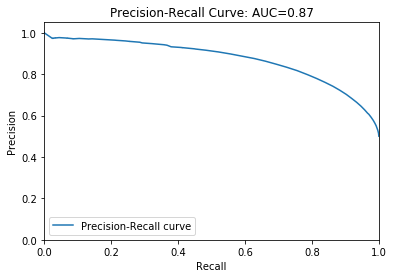

['joblib_data/clf_random_forest_porter_svd.joblib']

In [98]:
score_model(clf, X_train_tfidf_Porter_svd, X_test_tfidf_Porter_svd, y_train, y_test)
dump(clf, "joblib_data/clf_random_forest_porter_svd.joblib")

### Lancaster

In [99]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_Lancaster_svd, y_train)

CPU times: user 19min 11s, sys: 7.79 s, total: 19min 19s
Wall time: 2min 46s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [100]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster_svd)

CPU times: user 10.6 s, sys: 1.24 s, total: 11.8 s
Wall time: 4.09 s


Train Accuracy       0.98497
Test Accuracy        0.79111
Test Precision       0.81444
Test Recall          0.75426
F1                   0.78319
F2                   0.76557
P/R AUC              0.87294
              precision    recall  f1-score   support

       False    0.77097   0.82799   0.79846    164923
        True    0.81444   0.75426   0.78319    165077

   micro avg    0.79111   0.79111   0.79111    330000
   macro avg    0.79270   0.79112   0.79083    330000
weighted avg    0.79271   0.79111   0.79082    330000



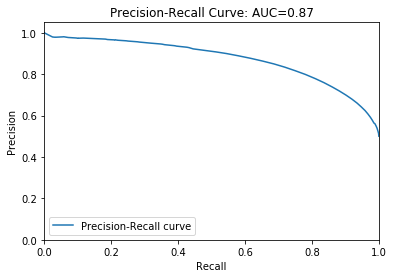

['joblib_data/clf_random_forest_lancaster_svd.joblib']

In [101]:
score_model(clf, X_train_tfidf_Lancaster_svd, X_test_tfidf_Lancaster_svd, y_train, y_test)
dump(clf, "joblib_data/clf_random_forest_lancaster_svd.joblib")

### Pystemmer

In [102]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_pystemmer_svd, y_train)

NameError: name 'X_train_tfidf_pystemmer_svd' is not defined

In [103]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer_svd)

NameError: name 'X_test_tfidf_pystemmer_svd' is not defined

In [104]:
score_model(clf, X_train_tfidf_pystemmer_svd, X_test_tfidf_pystemmer_svd, y_train, y_test)
dump(clf, "joblib_data/clf_random_forest_pystemmer_svd.joblib")

NameError: name 'X_train_tfidf_pystemmer_svd' is not defined

## LinearSVC

In [105]:
from sklearn import svm

### No_stemmer

In [106]:
%%time
clf = svm.LinearSVC(random_state=42)
clf.fit(X_train_tfidf_nostemmer_svd, y_train)

CPU times: user 40.3 s, sys: 5.31 s, total: 45.6 s
Wall time: 48.9 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [107]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer_svd)

CPU times: user 245 ms, sys: 866 ms, total: 1.11 s
Wall time: 2.31 s


In [108]:
score_model(clf, X_train_tfidf_nostemmer_svd, X_test_tfidf_nostemmer_svd, y_train, y_test, probabilities=False)
dump(clf, "joblib_data/clf_linearsvc_nostemmer_svd.joblib")

Train Accuracy       0.80142
Test Accuracy        0.80142
Test Precision       0.81334
Test Recall          0.78263
F1                   0.79769
F2                   0.78858
              precision    recall  f1-score   support

       False    0.79035   0.82022   0.80501    164923
        True    0.81334   0.78263   0.79769    165077

   micro avg    0.80142   0.80142   0.80142    330000
   macro avg    0.80184   0.80142   0.80135    330000
weighted avg    0.80185   0.80142   0.80135    330000



['joblib_data/clf_linearsvc_nostemmer_svd.joblib']

### Porter

In [109]:
%%time
clf = svm.LinearSVC(random_state=42)
clf.fit(X_train_tfidf_Porter_svd, y_train)

CPU times: user 32.1 s, sys: 9.04 s, total: 41.2 s
Wall time: 46.5 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [110]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)

CPU times: user 303 ms, sys: 998 ms, total: 1.3 s
Wall time: 2.25 s


In [111]:
score_model(clf, X_train_tfidf_Porter_svd, X_test_tfidf_Porter_svd, y_train, y_test, probabilities=False)
dump(clf, "joblib_data/clf_linearsvc_porter_svd.joblib")

Train Accuracy       0.80271
Test Accuracy        0.80256
Test Precision       0.81153
Test Recall          0.78841
F1                   0.79980
F2                   0.79293
              precision    recall  f1-score   support

       False    0.79409   0.81673   0.80525    164923
        True    0.81153   0.78841   0.79980    165077

   micro avg    0.80256   0.80256   0.80256    330000
   macro avg    0.80281   0.80257   0.80253    330000
weighted avg    0.80281   0.80256   0.80252    330000



['joblib_data/clf_linearsvc_porter_svd.joblib']

### Lancaster

In [112]:
%%time
clf = svm.LinearSVC(random_state=42)
clf.fit(X_train_tfidf_Lancaster_svd, y_train)

CPU times: user 32.7 s, sys: 7.09 s, total: 39.8 s
Wall time: 45.4 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [113]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster_svd)

CPU times: user 254 ms, sys: 688 ms, total: 942 ms
Wall time: 1.86 s


In [114]:
score_model(clf, X_train_tfidf_Lancaster_svd, X_test_tfidf_Lancaster_svd, y_train, y_test, probabilities=False)
dump(clf, "joblib_data/clf_linearsvc_lancaster_svd.joblib")

Train Accuracy       0.80124
Test Accuracy        0.80101
Test Precision       0.80893
Test Recall          0.78844
F1                   0.79855
F2                   0.79245
              precision    recall  f1-score   support

       False    0.79348   0.81360   0.80341    164923
        True    0.80893   0.78844   0.79855    165077

   micro avg    0.80101   0.80101   0.80101    330000
   macro avg    0.80120   0.80102   0.80098    330000
weighted avg    0.80121   0.80101   0.80098    330000



['joblib_data/clf_linearsvc_lancaster_svd.joblib']

### Pystemmer

In [115]:
%%time
clf = svm.LinearSVC(random_state=42)
clf.fit(X_train_tfidf_pystemmer_svd, y_train)

NameError: name 'X_train_tfidf_pystemmer_svd' is not defined

In [116]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer_svd)

NameError: name 'X_test_tfidf_pystemmer_svd' is not defined

In [117]:
score_model(clf, X_train_tfidf_pystemmer_svd, X_test_tfidf_pystemmer_svd, y_train, y_test, probabilities=False)
dump(clf, "joblib_data/clf_linearsvc_pystemmer_svd.joblib")

NameError: name 'X_train_tfidf_pystemmer_svd' is not defined

## SVC

### No stemmer

In [118]:
clf = svm.SVC(random_state=42, max_iter=500)

In [119]:
%%time
clf.fit(X_train_tfidf_nostemmer_svd, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 3min 15s, sys: 4.44 s, total: 3min 20s
Wall time: 3min 24s


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=500, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

In [120]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer_svd)

CPU times: user 1min 14s, sys: 1.1 s, total: 1min 15s
Wall time: 1min 16s


In [121]:
score_model(clf, X_train_tfidf_nostemmer_svd, X_test_tfidf_nostemmer_svd, y_train, y_test, probabilities=False)
dump(clf, "joblib_data/clf_svc_nostemmer_svd.joblib")

Train Accuracy       0.50871
Test Accuracy        0.50919
Test Precision       0.50477
Test Recall          0.99654
F1                   0.67012
F2                   0.83403
              precision    recall  f1-score   support

       False    0.86070   0.02139   0.04175    164923
        True    0.50477   0.99654   0.67012    165077

   micro avg    0.50919   0.50919   0.50919    330000
   macro avg    0.68274   0.50897   0.35593    330000
weighted avg    0.68265   0.50919   0.35608    330000



['joblib_data/clf_svc_nostemmer_svd.joblib']

### Porter

In [122]:
clf = svm.SVC(random_state=42, max_iter=500)

In [123]:
%%time
clf.fit(X_train_tfidf_Porter_svd, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 3min 7s, sys: 3.01 s, total: 3min 10s
Wall time: 3min 13s


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=500, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

In [124]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)

CPU times: user 1min 13s, sys: 1.1 s, total: 1min 14s
Wall time: 1min 15s


In [125]:
score_model(clf, X_train_tfidf_Porter_svd, X_test_tfidf_Porter_svd, y_train, y_test, probabilities=False)
dump(clf, "joblib_data/clf_svc_porter_svd.joblib")

Train Accuracy       0.51260
Test Accuracy        0.51288
Test Precision       0.50668
Test Recall          0.99433
F1                   0.67129
F2                   0.83383
              precision    recall  f1-score   support

       False    0.84519   0.03098   0.05978    164923
        True    0.50668   0.99433   0.67129    165077

   micro avg    0.51288   0.51288   0.51288    330000
   macro avg    0.67593   0.51266   0.36553    330000
weighted avg    0.67585   0.51288   0.36568    330000



['joblib_data/clf_svc_porter_svd.joblib']

### Lancaster

In [126]:
clf = svm.SVC(random_state=42, max_iter=500)

In [127]:
%%time
clf.fit(X_train_tfidf_Lancaster_svd, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 3min 3s, sys: 3.87 s, total: 3min 7s
Wall time: 3min 11s


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=500, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

In [128]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster_svd)

CPU times: user 1min 13s, sys: 1.14 s, total: 1min 14s
Wall time: 1min 16s


In [129]:
score_model(clf, X_train_tfidf_Lancaster_svd, X_test_tfidf_Lancaster_svd, y_train, y_test, probabilities=False)
dump(clf, "joblib_data/clf_svc_lancaster_svd.joblib")

Train Accuracy       0.50668
Test Accuracy        0.50742
Test Precision       0.50402
Test Recall          0.95906
F1                   0.66078
F2                   0.81237
              precision    recall  f1-score   support

       False    0.57459   0.05535   0.10097    164923
        True    0.50402   0.95906   0.66078    165077

   micro avg    0.50742   0.50742   0.50742    330000
   macro avg    0.53931   0.50720   0.38087    330000
weighted avg    0.53929   0.50742   0.38100    330000



['joblib_data/clf_svc_lancaster_svd.joblib']

### Pystemmer

In [130]:
clf = svm.SVC(random_state=42, max_iter=500)

In [131]:
%%time
clf.fit(X_train_tfidf_pystemmer_svd, y_train)

NameError: name 'X_train_tfidf_pystemmer_svd' is not defined

In [132]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer_svd)

NameError: name 'X_test_tfidf_pystemmer_svd' is not defined

In [133]:
score_model(clf, X_train_tfidf_pystemmer_svd, X_test_tfidf_pystemmer_svd, y_train, y_test, probabilities=False)
dump(clf, "joblib_data/clf_svc_pystemmer_svd.joblib")

NameError: name 'X_train_tfidf_pystemmer_svd' is not defined

## Adaboost
### 10 estimators

In [134]:
from sklearn.ensemble import AdaBoostClassifier

In [135]:
%%time
clf = AdaBoostClassifier(n_estimators=10, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

CPU times: user 3min 56s, sys: 3.1 s, total: 3min 59s
Wall time: 4min 3s


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=10, random_state=0)

Train Accuracy       0.72099
Test Accuracy        0.72020
Test Precision       0.73870
Test Recall          0.68185
F1                   0.70914
F2                   0.69251
P/R AUC              0.79106
              precision    recall  f1-score   support

       False    0.70433   0.75858   0.73045    164923
        True    0.73870   0.68185   0.70914    165077

   micro avg    0.72020   0.72020   0.72020    330000
   macro avg    0.72151   0.72021   0.71979    330000
weighted avg    0.72152   0.72020   0.71979    330000



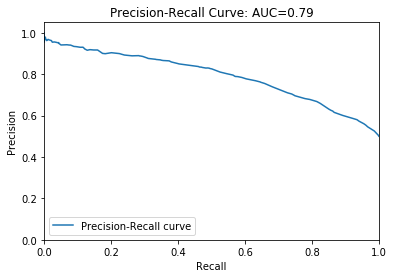

CPU times: user 4.56 s, sys: 2.1 s, total: 6.66 s
Wall time: 7.94 s


In [136]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)
score_model(clf, X_train_tfidf_Porter_svd, X_test_tfidf_Porter_svd, y_train, y_test)

### 15 estimators

In [137]:
%%time
clf = AdaBoostClassifier(n_estimators=15, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

CPU times: user 5min 47s, sys: 1.08 s, total: 5min 48s
Wall time: 5min 49s


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=15, random_state=0)

Train Accuracy       0.72460
Test Accuracy        0.72287
Test Precision       0.72784
Test Recall          0.71238
F1                   0.72003
F2                   0.71542
P/R AUC              0.80706
              precision    recall  f1-score   support

       False    0.71810   0.73338   0.72566    164923
        True    0.72784   0.71238   0.72003    165077

   micro avg    0.72287   0.72287   0.72287    330000
   macro avg    0.72297   0.72288   0.72284    330000
weighted avg    0.72298   0.72287   0.72284    330000



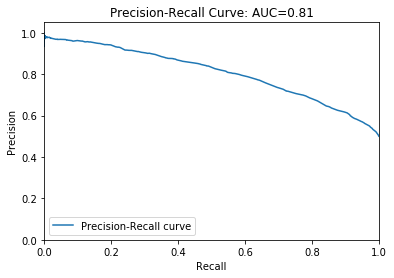

CPU times: user 5.85 s, sys: 997 ms, total: 6.85 s
Wall time: 6.96 s


In [138]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)
score_model(clf, X_train_tfidf_Porter_svd, X_test_tfidf_Porter_svd, y_train, y_test)

Increasing the number of estimators lead to an improvement in performances
## 20 estimators

In [139]:
%%time
clf = AdaBoostClassifier(n_estimators=20, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

CPU times: user 7min 40s, sys: 1.74 s, total: 7min 42s
Wall time: 7min 43s


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=20, random_state=0)

Train Accuracy       0.73500
Test Accuracy        0.73431
Test Precision       0.74745
Test Recall          0.70813
F1                   0.72726
F2                   0.71566
P/R AUC              0.81516
              precision    recall  f1-score   support

       False    0.72247   0.76051   0.74100    164923
        True    0.74745   0.70813   0.72726    165077

   micro avg    0.73431   0.73431   0.73431    330000
   macro avg    0.73496   0.73432   0.73413    330000
weighted avg    0.73496   0.73431   0.73413    330000



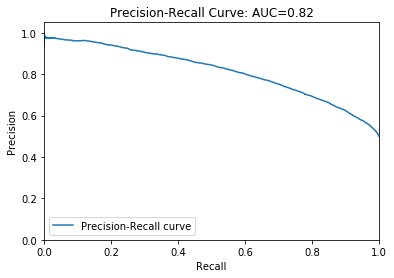

CPU times: user 7.33 s, sys: 1.94 s, total: 9.27 s
Wall time: 9.72 s


In [140]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)
score_model(clf, X_train_tfidf_Porter_svd, X_test_tfidf_Porter_svd, y_train, y_test)

Performances are a bit better. Apparently the best configuration is the "20 estimators" one. Let's now build predictive models for all 4 representations.

## 20 Estimators
### No stemming

In [141]:
%%time
clf = AdaBoostClassifier(n_estimators=20, random_state=0)
clf.fit(X_train_tfidf_nostemmer_svd, y_train)

CPU times: user 7min 57s, sys: 3.58 s, total: 8min 1s
Wall time: 8min 4s


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=20, random_state=0)

In [142]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer_svd)

CPU times: user 1.11 s, sys: 959 ms, total: 2.07 s
Wall time: 3.15 s


Train Accuracy       0.73744
Test Accuracy        0.73825
Test Precision       0.75466
Test Recall          0.70638
F1                   0.72972
F2                   0.71554
P/R AUC              0.81783
              precision    recall  f1-score   support

       False    0.72379   0.77015   0.74625    164923
        True    0.75466   0.70638   0.72972    165077

   micro avg    0.73825   0.73825   0.73825    330000
   macro avg    0.73923   0.73826   0.73799    330000
weighted avg    0.73924   0.73825   0.73798    330000



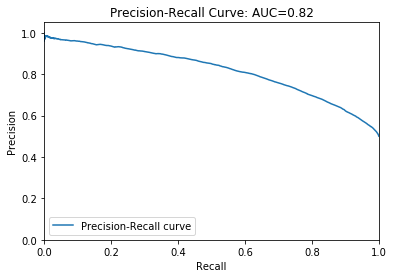

['joblib_data/clf_adaboost_nostemmer_svd.joblib']

In [143]:
score_model(clf, X_train_tfidf_nostemmer_svd, X_test_tfidf_nostemmer_svd, y_train, y_test)
dump(clf, "joblib_data/clf_adaboost_nostemmer_svd.joblib")

### Porter

In [144]:
%%time
clf = AdaBoostClassifier(n_estimators=20, random_state=0)
clf.fit(X_train_tfidf_Porter_svd, y_train)

CPU times: user 7min 33s, sys: 3.76 s, total: 7min 36s
Wall time: 7min 40s


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=20, random_state=0)

In [145]:
%%time
predictions = clf.predict(X_test_tfidf_Porter_svd)

CPU times: user 1.37 s, sys: 1.14 s, total: 2.51 s
Wall time: 4.38 s


Train Accuracy       0.73500
Test Accuracy        0.73431
Test Precision       0.74745
Test Recall          0.70813
F1                   0.72726
F2                   0.71566
P/R AUC              0.81516
              precision    recall  f1-score   support

       False    0.72247   0.76051   0.74100    164923
        True    0.74745   0.70813   0.72726    165077

   micro avg    0.73431   0.73431   0.73431    330000
   macro avg    0.73496   0.73432   0.73413    330000
weighted avg    0.73496   0.73431   0.73413    330000



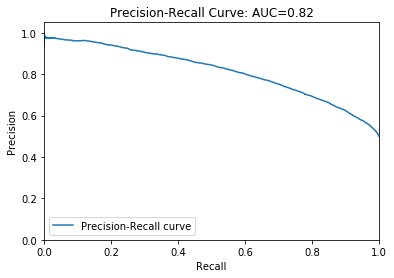

['joblib_data/clf_adaboost_porter_svd.joblib']

In [146]:
score_model(clf, X_train_tfidf_Porter_svd, X_test_tfidf_Porter_svd, y_train, y_test)
dump(clf, "joblib_data/clf_adaboost_porter_svd.joblib")

### Lancaster

In [147]:
%%time
clf = AdaBoostClassifier(n_estimators=20, random_state=0)
clf.fit(X_train_tfidf_Lancaster_svd, y_train)

CPU times: user 7min 39s, sys: 4.19 s, total: 7min 43s
Wall time: 7min 47s


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=20, random_state=0)

In [148]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster_svd)

CPU times: user 1.2 s, sys: 917 ms, total: 2.12 s
Wall time: 3.24 s


Train Accuracy       0.73096
Test Accuracy        0.73092
Test Precision       0.74991
Test Recall          0.69331
F1                   0.72050
F2                   0.70394
P/R AUC              0.81145
              precision    recall  f1-score   support

       False    0.71459   0.76857   0.74060    164923
        True    0.74991   0.69331   0.72050    165077

   micro avg    0.73092   0.73092   0.73092    330000
   macro avg    0.73225   0.73094   0.73055    330000
weighted avg    0.73226   0.73092   0.73054    330000



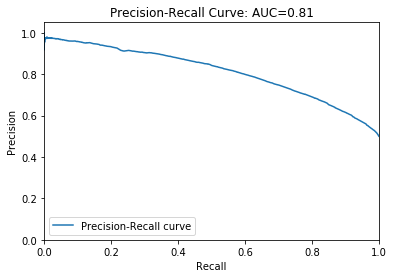

['joblib_data/clf_adaboost_Lancaster_svd.joblib']

In [149]:
score_model(clf, X_train_tfidf_Lancaster_svd, X_test_tfidf_Lancaster_svd, y_train, y_test)
dump(clf, "joblib_data/clf_adaboost_Lancaster_svd.joblib")

### Pystemmer

In [150]:
%%time
clf = AdaBoostClassifier(n_estimators=20, random_state=0)
clf.fit(X_train_tfidf_pystemmer_svd, y_train)

NameError: name 'X_train_tfidf_pystemmer_svd' is not defined

In [151]:
%%time
predictions = clf.predict(X_test_tfidf_pystemmer_svd)

NameError: name 'X_test_tfidf_pystemmer_svd' is not defined

In [152]:
score_model(clf, X_train_tfidf_pystemmer_svd, X_test_tfidf_pystemmer_svd, y_train, y_test)
dump(clf, "joblib_data/clf_adaboost_pystemmer_svd.joblib")

NameError: name 'X_train_tfidf_pystemmer_svd' is not defined

The best vectorizer was the 'No stemmer' one: because of GH constraints I will zip it.

In [153]:
import gzip
import shutil
with open("joblib_data/tfidf_vect_nostemmer.joblib", 'rb') as f_in, gzip.open("joblib_data/tfidf_vect_nostemmer.joblib.zip", 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)